# Image classification with regularized logistic regression

/Users/tapankhaladkar/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


-- Epoch 1
Norm: 0.75, NNZs: 274, Bias: -0.000860, T: 9902, Avg. loss: 0.042060
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.83, NNZs: 241, Bias: -0.000885, T: 19804, Avg. loss: 0.031477
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.89, NNZs: 225, Bias: -0.000691, T: 29706, Avg. loss: 0.029708
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.93, NNZs: 222, Bias: -0.000399, T: 39608, Avg. loss: 0.028867
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 0.97, NNZs: 219, Bias: -0.000036, T: 49510, Avg. loss: 0.028318
Total training time: 0.13 seconds.
-- Epoch 6
Norm: 1.00, NNZs: 217, Bias: 0.000369, T: 59412, Avg. loss: 0.027993
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 1.03, NNZs: 213, Bias: 0.000790, T: 69314, Avg. loss: 0.027681
Total training time: 0.18 seconds.
-- Epoch 8
Norm: 1.05, NNZs: 209, Bias: 0.001222, T: 79216, Avg. loss: 0.027504
Total training time: 0.21 seconds.
Convergence after 8 epochs took 0.21 seconds
train:  0.0021207836800646333	t

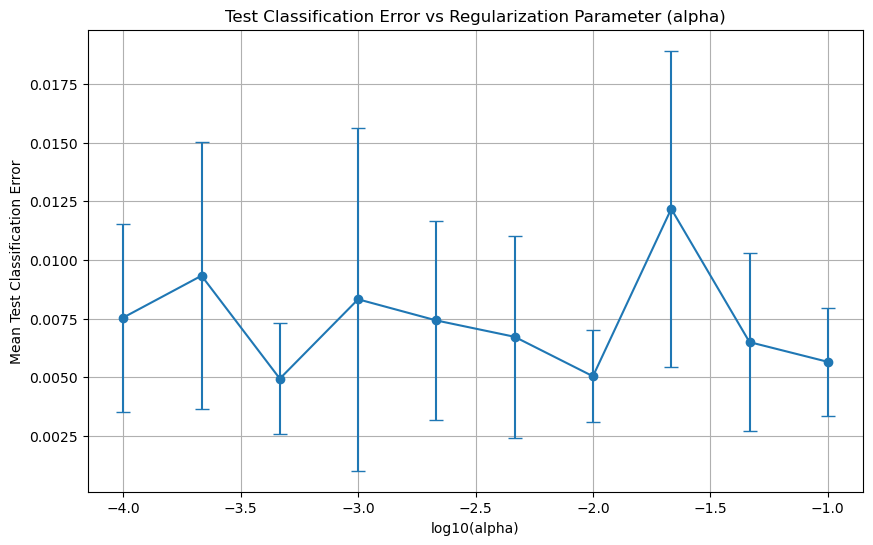

The optimal value of alpha is: 0.00046415888336127773


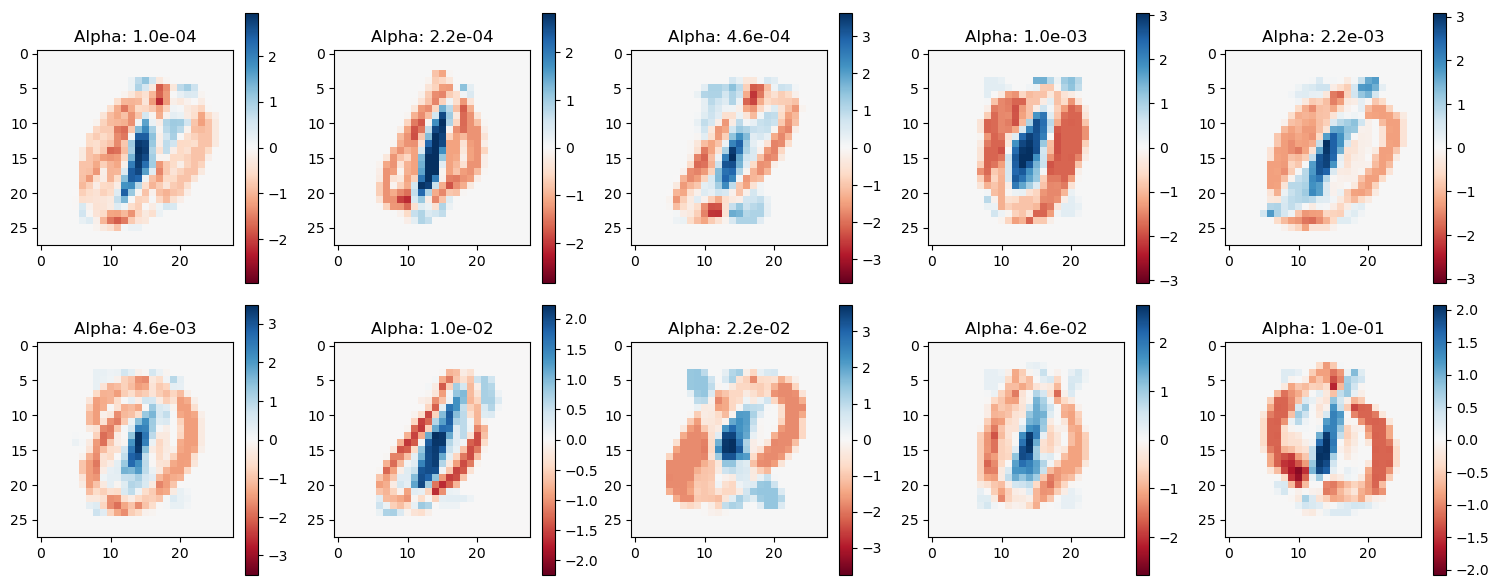

In [18]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test


def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    error = np.mean(y_pred != y)
    return error


X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log_loss', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)

test = classification_error(clf, X_test, y_test)
train = classification_error(clf, X_train, y_train)

train_error = 1 - clf.score(X_train, y_train)
test_error = 1 - clf.score(X_test, y_test)

print('train: ', train, end='\t')
print('test: ', test)
print(f"Train Error: {train_error}")
print(f"Test Error: {test_error}")

alphas = np.logspace(-4, -1, 10)

mean_test_errors = []
std_test_errors = []

for alpha in alphas:
    test_errors = []
    
    for _ in range(10):
        clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, penalty='l1', alpha=alpha, learning_rate='invscaling', power_t=0.5, eta0=0.01, verbose=0)

        clf.fit(X_train_sub, y_train_sub)

        test_error = classification_error(clf, X_test, y_test)
        test_errors.append(test_error)
    
    mean_test_errors.append(np.mean(test_errors))
    std_test_errors.append(np.std(test_errors))
    
    clf.fit(X_train_sub, y_train_sub)


plt.figure(figsize=(10, 6))
plt.errorbar(np.log10(alphas), mean_test_errors, yerr=std_test_errors, fmt='-o', capsize=5)
plt.xlabel('log10(alpha)')
plt.ylabel('Mean Test Classification Error')
plt.title('Test Classification Error vs Regularization Parameter (alpha)')
plt.grid(True)
plt.show()

optimal_alpha_index = np.argmin(mean_test_errors)
optimal_alpha = alphas[optimal_alpha_index]

print(f"The optimal value of alpha is: {optimal_alpha}")

plt.figure(figsize=(15, 6))

for i, alpha in enumerate(alphas):
    clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, penalty='l1', alpha=alpha, learning_rate='invscaling', power_t=0.5, eta0=0.01, verbose=0)

    clf.fit(X_train_sub, y_train_sub)

    coef = clf.coef_.reshape(28, 28)
    scale = np.abs(coef).max()

    plt.subplot(2, 5, i + 1)
    plt.imshow(coef, cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
    plt.title(f'Alpha: {alpha:.1e}')
    plt.colorbar()

plt.tight_layout()
plt.show()

